In [1]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [2]:
import gym
import matplotlib
import numpy as np
import random
import itertools
import sys
from collections import defaultdict
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
env = CliffWalkingEnv()

In [6]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [7]:
action = ["up", "right", "down", "left"]

In [8]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [4]:
# Where am I? -> in "x" state
print ("Current state", env.s)
# What are my options? -> 4 action
print ("Transitions from current state:", env.P[env.s])

Current state 36
<CliffWalkingEnv instance>
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [10]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?
# t_prob: What is probability of ending up in next state taking that action?
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [11]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [12]:
%%time 

# generate a episode in cliffwalking environment for above sample_policy
def generate_episode(policy, verbose=False):
    episode = []
    env = CliffWalkingEnv()
    curr_state = env.reset()
    probs = policy(curr_state)
    action = np.random.choice(np.arange(len(probs)), p=probs)
    
    while True:
        if verbose:
            print ("Current observation:")
            print ("Current poistion:", curr_state)
            #print (env.render())
        
        next_obs, reward, is_terminal, _ = env.step(action)
        
        if verbose:
            print ("Action taken:", actions[action])
            print ("Next observation:", next_obs)
            print ("Reward recieved:", reward)
            print ("Terminal state:", is_terminal)
            #print (env.render())
            print ("-"*20)
        episode.append((curr_state, action, reward))
        
        # Pick the next action
        next_probs = policy(next_state)
        next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
    
        curr_state = next_obs
        action = next_action

        if (is_terminal):
            break

    return episode
    
Q = defaultdict(lambda: np.zeros(env.action_space.n))
policy = make_epsilon_greedy_policy(Q, 0.1, env.action_space.n)
e = generate_episode(policy)
#print ("Episode:", e)
print ("Length of episode:", len(e))

KeyboardInterrupt: 

In [13]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 1
        # Takes a lot a lot lot of time to run
        # ep = generate_episode(policy)
        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]
        
        #     td_target = reward + discount_factor * Q[next_state][next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, stats

In [14]:
%%time
Q, stats = sarsa(env, 200)

Episode 200/200.CPU times: user 419 ms, sys: 12.5 ms, total: 432 ms
Wall time: 449 ms


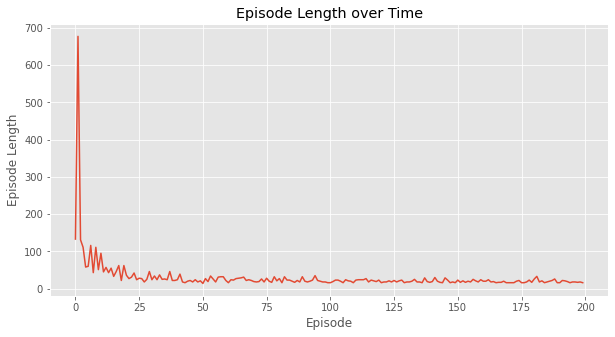

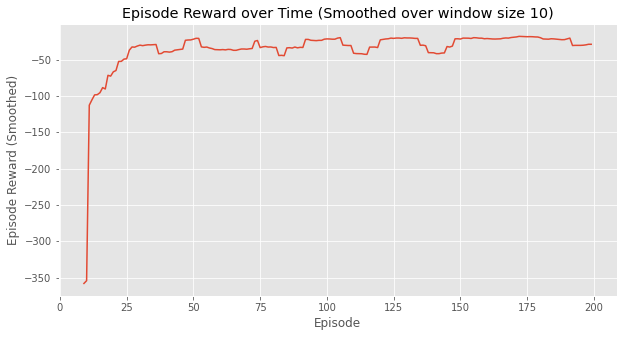

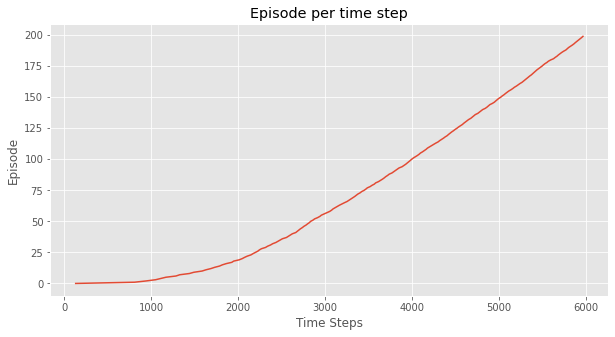

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [15]:
plot_episode_stats(stats)

In [16]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

In [17]:
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  0  0  0  1  0  0  1  2]
 [ 0  3  0  1  3  0  1  0  0  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['right' 'right' 'right' 'right' 'up' 'up' 'up' 'right' 'up' 'up'
  'right' 'down']
 ['up' 'left' 'up' 'right' 'left' 'up' 'right' 'up' 'up' 'right' 'right'
  'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-16.4543765  -15.46817603 -13.92649702 -12.50620383 -11.14970344
   -9.99069935  -9.0709957   -7.81554674  -6.2205194   -5.43772925
   -4.72893456  -3.35754564]
 [-16.5352103  -15.36415362 -14.2157058  -13.11205281 -12.10267947
  -10.39813611 -10.45709585  -8.29247712  -7.50599536  -6.55762147
   -3.15435633  -2.00014722]
 [-17.66061303 -15.70105184 -15.45237685 -14.11274707 -13.87114458
   -8.90988423  -7.84158817  -7.

In [20]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Approach : 1
        # Couldn't run this because SARSA never finished :(
        # ep = generate_episode(policy, False)

        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]

        #     best_next_action = np.argmax(Q[next_state])
        #     td_target = reward + discount_factor * Q[next_state][best_next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [21]:
%%time
Q, stats = q_learning(env, 500)

Episode 500/500.CPU times: user 222 ms, sys: 43 ms, total: 265 ms
Wall time: 240 ms


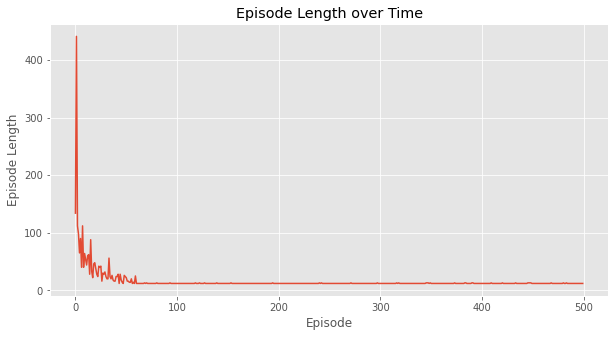

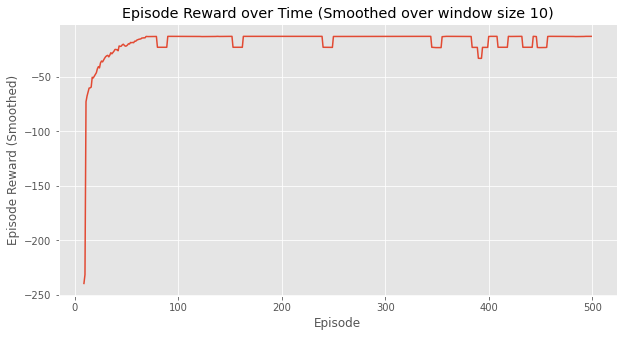

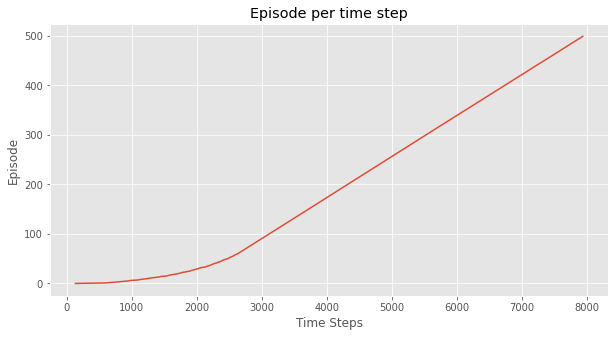

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [22]:
plot_episode_stats(stats)

In [23]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

In [24]:
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  2  2  1  1  1  2  1  1  2]
 [ 1  1  0  1  3  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'down' 'down' 'right' 'right' 'right' 'down'
  'right' 'right' 'down']
 ['right' 'right' 'up' 'right' 'left' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-11.1339619  -10.628736    -9.95425626  -9.1882717   -8.46938868
   -7.64126222  -6.95511374  -6.18331443  -5.3061077   -4.5489931
   -3.70860939  -2.94821961]
 [-11.36207581 -10.78245174  -9.89770311  -9.14756348  -8.31137949
   -7.51620908  -6.63177683  -5.76088237  -4.84638692  -3.942866
   -2.98186038  -1.99986803]
 [-12.         -11.         -10.          -9.          -8.
   -7.          -6. 

In [15]:
def b_pessimistic_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, beta=0.1):
    """
    B-pessimistic Q-Learning algorithm: the B-pessimistic action-values represent the
    expected value of performing an action followed by actions which are highest valued
    with probability 1−B, or lowest valued with probability B.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Approach : 1
        # Couldn't run this because SARSA never finished :(
        # ep = generate_episode(policy, False)

        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]

        #     best_next_action = np.argmax(Q[next_state])
        #     td_target = reward + discount_factor * Q[next_state][best_next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            worst_next_action = np.argmin(Q[next_state])
            td_target = reward + discount_factor * ((1-beta) * Q[next_state][best_next_action] + beta * Q[next_state][worst_next_action])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [24]:
%%time
Q, stats = b_pessimistic_q_learning(env, 500)

Episode 500/500.CPU times: user 257 ms, sys: 56.4 ms, total: 313 ms
Wall time: 277 ms


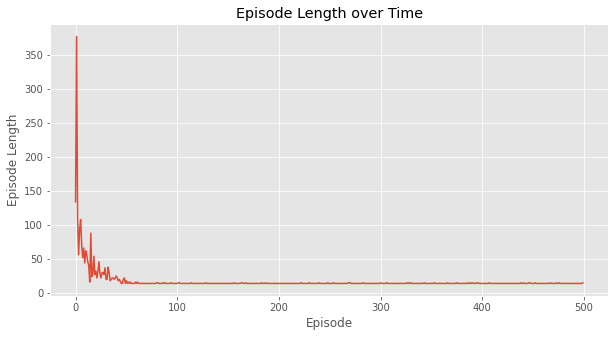

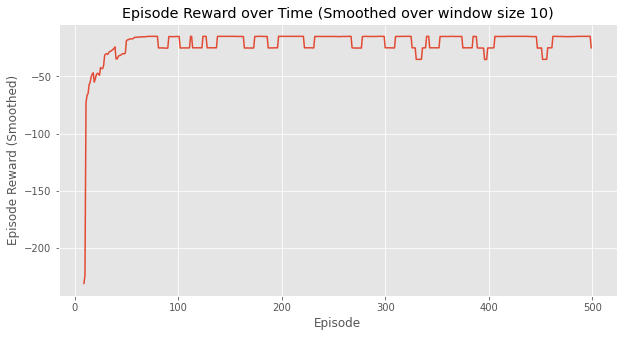

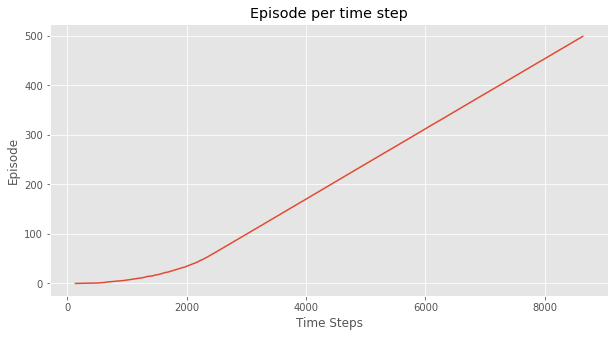

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [25]:
plot_episode_stats(stats)

In [26]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

In [27]:
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 0  3  2  1  1  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  3  0  1  3  3  0  0  3  0  0  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['up' 'left' 'down' 'right' 'right' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'up' 'right' 'left' 'left' 'up' 'up' 'left' 'up' 'up'
  'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-13.61144902 -12.96287735 -12.14361269 -11.27832729 -10.25794323
   -9.28812708  -8.31782208  -7.34936904  -6.36605199  -5.37125687
   -4.3431811   -3.32747225]
 [-14.36370207 -13.34845328 -12.29041845 -11.23564205 -10.14628892
   -8.9668514   -7.7291742   -6.61783492  -5.51290505  -4.36024928
   -3.33083626  -2.27193974]
 [-15.4790487  -12.53399863 -10.45863416  -9.50846941  -7.27013518
   -7.34640101  -6.71567296  

In [7]:
###### DQN ######
from collections import namedtuple, deque
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
import numpy as np

"""
A named tuple representing a single transition in the environment.
It essentially maps (state, action) pairs to their (next_state, reward)
"""
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


"""
 A cyclic buffer of bounded size that holds the transitions observed recently.
 It also implements a .sample() method for selecting a random batch of transitions for training.
"""
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

"""
A class that implements DQN based on this blog post:
https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998
"""
class DQN():
    
    def __init__(self, num_states, num_actions, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_states = num_states
        self.num_actions = num_actions
        # self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.batch_size = batch_size
        self.model = build_network()
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        
    def build_network(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.numStates, activation='tanh'))
        model.add(Dense(self.numActions, activation='linear'))
        
        model.compile(loss=Huber, optimizer='adam', metrics=['accuracy'])
        return model
    
    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))
        